In [1]:
using Pkg

projectdir_static = dirname(Base.active_project())

projectdirx(args...) = joinpath(projectdir_static, args...)

# Generate functions to access the path of default subdirectories.
for dir_type ∈ ("data", "src", "plots", "scripts", "papers")
    function_name = Symbol(dir_type * "dirx")
    @eval begin
        $function_name(args...) = projectdirx($dir_type, args...)
    end
end

using DrWatson

@quickactivate "TissueRigidity"
 
projectname()

"TissueRigidity"

In [2]:
using DifferentialEquations
using StatsBase
using CairoMakie
using XLSX
using DataFrames
using Optimization, OptimizationPolyalgorithms, SciMLSensitivity,OptimizationOptimJL,OptimizationBBO,OptimizationNOMAD

In [ ]:
include(srcdirx("Plotting&Utility.jl"))
include(srcdirx("FittingFunctions.jl"))
# include(srcdirx("old/FittingFunctions_old_cmax.jl"))

include(srcdirx("NodalLefty_E.jl"))

exp_name = "NodalLefty_RelayDiffusion_v2"

include(srcdirx("ExperimentSetups/" * exp_name * ".jl"))

include(scriptsdirx("LoadData.jl"));

In [ ]:
α_range = 0.7:0.01:0.95

fig = Figure(size = (500,300))
ax1 = Axis(fig[1,1],title = "Porosity",ylabel = L"\phi(\alpha)",xlabel = L"\alpha")

lines!(ax1, α_range,[ϕ(α) for α in α_range])

fig

In [ ]:
pv_orig = [DN0,DL0,kN0,kL0,kE,kNL,σN0,σL0,Na,NL,NE,LN,s0]
# pv_orig = load(datadirx() * "/sims/NodalLefty_DiffusionDominated_OptParmas.jld2")["OptimalParam"][3]

p_orig,p_cp_orig,p_lm_orig = get_params(pv_orig)

tspan = (0,Inf)

u0 = ones(Nc,4)

u0[:,1] .= 1e-10
u0[:,2] .= 1e-10
u0[:,3] .= 0.
u0[:,4] .= α0

prob = ODEProblem(nodal_lefty_spatial_diff!,u0,tspan,p_orig)

lb = copy(pv_orig)
ub = copy(pv_orig)

lb[1:2] = 0.9 .* lb[1:2]
ub[1:2] = 1.1 .* ub[1:2]

lb[3:end] = (1 - γ) .* lb[3:end]
ub[3:end] = (1 + γ) .* ub[3:end];

In [ ]:
orig_metrics = get_summary_metrics(pv_orig,prob,data,alpha_data,0.2)

In [ ]:
fig = Figure(size = (500,300))

ax = Axis(fig[1,1], xlabel = L"\text{time (mins)}", ylabel= L"\lambda_{1/2} \quad (\mu m)",ygridvisible = false,xgridvisible = false,ylabelcolor = :blue,yticklabelcolor = :blue)
ax_N = Axis(fig[1,1], xlabel = L"\text{Rescaled time, t}", ylabel= L"N(x=0,t)", yaxisposition = :right,ylabelcolor = :green,yticklabelcolor = :green,ygridvisible = false,xgridvisible = false,xticksvisible = false)

hidexdecorations!(ax_N)

sol = solve(prob, p = p_orig, FBDF(),abstol = de_abstol,reltol = de_reltol, maxiters = 1e6,callback = TerminateSteadyState(1e-6,1e-4),isoutofdomain = (u,p,t) -> any(x->x<0, u));

N_samp = 5000

λ_trange = LinRange(0.,sol.t[end],N_samp)

N0t = [sol(t)[1,1] for t in λ_trange]

λhalf,λhalf_max_t = get_lambda_half(sol,λ_trange)

c_max = maximum(sol(λhalf_max_t)[:,1])

lines!(ax,λ_trange ./ 60 ,λhalf,color = :blue)

lines!(ax_N,λ_trange ./ 60 ,N0t, color = :green)

vlines!(ax,λhalf_max_t / 60, color = :red, linestyle = :dash)

save(plotsdir(exp_name * "/OrigFits/LambdaHalfOverT.pdf"),fig)

fig

In [ ]:
fig = Figure(size = (1000,1000))

fig = plot_summary!(fig,[DN0,DL0,kN0,kL0,kE,kNL,σN0,σL0,Na,NL,NE,LN,s0],prob)

save(plotsdir(exp_name * "/OrigFits/Summary_orig.pdf"),fig)

fig


In [ ]:
ro_tuple = load("NodalLefty_RelayDiffusion_v2OptParamDiff.jld2")["param"]

In [ ]:
fig = Figure(size = (1200,1000))

β = 0.1

fig = plot_summary!(fig,[ro_tuple[:DN0],ro_tuple[:DL0],ro_tuple[:kN0],ro_tuple[:kL0],ro_tuple[:kE],ro_tuple[:kNL],ro_tuple[:σN0],1.1*ro_tuple[:σL0],ro_tuple[:Na],ro_tuple[:NL],ro_tuple[:NE],ro_tuple[:LN],ro_tuple[:s0]],prob)

fig

In [ ]:
# fix sigma N
# fix s0 

In [ ]:
save(plotsdir(exp_name * "/OptFits/Summary_oopt.pdf"),fig)

In [ ]:
γ = 0.99

lb = copy(pv_orig)
ub = copy(pv_orig)

lb[1:2] = 0.9 .* lb[1:2]
ub[1:2] = 1.1 .* ub[1:2]

# knl , sigma_n not large enough

# lb[3:end] = 0.5 .* lb[3:end]
# ub[3:end] = 1.5 .* ub[3:end];

lb[3:end] = 0.5 .* lb[3:end]
ub[3:end] = 2 .* ub[3:end];

lb[7] = 0.36

lb[end] = 4.99
ub[end] = 5.01

j = 1.

lb_pow = copy(pv_orig)
ub_pow = copy(pv_orig)

lb_pow[1:2] = 0.9 .* lb_pow[1:2]
ub_pow[1:2] = 1.1 .* ub_pow[1:2]

lb_pow[3:end] = 10^(-j) .* lb_pow[3:end]
ub_pow[3:end] = 10^(j) .* ub_pow[3:end];

# lb_pow[6] = 50.
# ub_pow[6] = 1000

# [DN0,DL0,kN0,kL0,kE,kNL,σN0,σL0,Na,NL,NE,LN,s0]

lb_pow[7] = 0.36

lb_pow[end] = 4.99
ub_pow[end] = 5.01



# lb_pow1 = vcat(lb_pow1,[0.1])
# ub_pow1 = vcat(ub_pow1,[0.3])

In [ ]:
include(srcdirx("FittingFunctions.jl"))

In [ ]:
pv_start = copy(pv_orig)

# pv_start[6] = 75.
# pv_start[end] = 0.75
# pv_start1 = vcat(pv_start,[0.2])

check_inbounds(pv_start,lb,ub)

# check_inbounds(pv_start1,lb_pow1,ub_pow1)

In [ ]:
using BlackBoxOptim

In [ ]:
loss_tuple_bbo(x) = loss_tuple_safe(x,prob,data,alpha_data,0.2,false,false)

In [18]:
res = bboptimize(loss_tuple_bbo; Method=:borg_moea,
            FitnessScheme=ParetoFitnessScheme{2}(is_minimizing=true),
            SearchRange= zip(lb_pow,ub_pow) |> collect, NumDimensions=length(lb), ϵ=0.05,
            MaxSteps=50, TraceInterval=1.0, TraceMode=:verbose);

Starting optimization with optimizer BlackBoxOptim.BorgMOEA{EpsBoxDominanceFitnessScheme{2, Float64, true, typeof(sum)}, BlackBoxOptim.ProblemEvaluator{Tuple{Float64, Float64}, IndexedTupleFitness{2, Float64}, EpsBoxArchive{2, Float64, EpsBoxDominanceFitnessScheme{2, Float64, true, typeof(sum)}}, FunctionBasedProblem{typeof(loss_tuple_bbo), ParetoFitnessScheme{2, Float64, true, typeof(sum)}, ContinuousRectSearchSpace, Nothing}}, FitPopulation{IndexedTupleFitness{2, Float64}}, FixedGeneticOperatorsMixture, RandomBound{ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
pop.size=

50 arch.size=0 n.restarts=0
P(recombine):
  #1(BlackBoxOptim

.DiffEvoRandBin{3}(0.7, 0.6))=0.1429
  #2(

SimulatedBinaryCrossover(0.2, 3.0, 0.25))=0.1429
  #3(

SimplexCrossover{3}(1.1))=0.1429
  #4(ParentCentricCrossover

{2}(0.1, 0.5))=0.1429
  #5(

ParentCentricCrossover{3}(0.1, 0.5))=0.1429
  #6(UnimodalNormalDistributionCrossover

{2}(0.5, 0.1))=0.1429
  #7(

UnimodalNormalDistributionCrossover{3}(0.5, 0.1))=0.1429


420.19 secs, 51 evals, 1 steps, fitness=(0.19184, 0.00458) agg=0.19642
pop.size=50 arch.size=1 n.restarts=0
P(recombine):
  #1(BlackBoxOptim.DiffEvoRandBin{3}(0.7, 0.6))=0.1429
  #2(SimulatedBinaryCrossover(0.2, 3.0, 0.25))=0.1429
  #3(SimplexCrossover{3}(1.1))=0.1429
  #4(ParentCentricCrossover{2}(0.1, 0.5))=0.1429
  #5(ParentCentricCrossover{3}(0.1, 0.5))=0.1429
  #6(UnimodalNormalDistributionCrossover{2}(0.5, 0.1))=0.1429
  #7(UnimodalNormalDistributionCrossover{3}(0.5, 0.1))=0.1429


428.82 secs, 52 evals, 2 steps, fitness=(0.19184, 0.00458) agg=0.19642
pop.size=50 arch.size=1 n.restarts=0
P(recombine):
  #1(BlackBoxOptim.DiffEvoRandBin{3}(0.7, 0.6))=0.1429
  #2(SimulatedBinaryCrossover(0.2, 3.0, 0.25))=0.1429
  #3(SimplexCrossover{3}(1.1))=0.1429
  #4(ParentCentricCrossover{2}(0.1, 0.5))=0.1429
  #5(ParentCentricCrossover{3}(0.1, 0.5))=0.1429
  #6(UnimodalNormalDistributionCrossover{2}(0.5, 0.1))=0.1429
  #7(UnimodalNormalDistributionCrossover{3}(0.5, 0.1))=0.1429


438.29 secs, 53 evals, 3 steps, fitness=(0.19184, 0.00458) agg=0.19642
pop.size=50 arch.size=1 n.restarts=0
P(recombine):
  #1(BlackBoxOptim.DiffEvoRandBin{3}(0.7, 0.6))=0.1429
  #2(SimulatedBinaryCrossover(0.2, 3.0, 0.25))=0.1429
  #3(SimplexCrossover{3}(1.1))=0.1429
  #4(ParentCentricCrossover{2}(0.1, 0.5))=0.1429
  #5(ParentCentricCrossover{3}(0.1, 0.5))=0.1429
  #6(UnimodalNormalDistributionCrossover{2}(0.5, 0.1))=0.1429
  #7(UnimodalNormalDistributionCrossover{3}(0.5, 0.1))=0.1429


446.90 secs, 54 evals, 4 steps, fitness=(0.16799, 0.00380) agg=0.17179
pop.size=50 arch.size=1 n.restarts=0
P(recombine):
  #1(BlackBoxOptim.DiffEvoRandBin{3}(0.7, 0.6))=0.1429
  #2(SimulatedBinaryCrossover(0.2, 3.0, 0.25))=0.1429
  #3(SimplexCrossover{3}(1.1))=0.1429
  #4(ParentCentricCrossover{2}(0.1, 0.5))=0.1429
  #5(ParentCentricCrossover{3}(0.1, 0.5))=0.1429
  #6(UnimodalNormalDistributionCrossover{2}(0.5, 0.1))=0.1429
  #7(UnimodalNormalDistributionCrossover{3}(0.5, 0.1))=0.1429


455.75 secs, 55 evals, 5 steps, fitness=(0.16799, 0.00380) agg=0.17179
pop.size=50 arch.size=1 n.restarts=0
P(recombine):
  #1(BlackBoxOptim.DiffEvoRandBin{3}(0.7, 0.6))=0.1429
  #2(SimulatedBinaryCrossover(0.2, 3.0, 0.25))=0.1429
  #3(SimplexCrossover{3}(1.1))=0.1429
  #4(ParentCentricCrossover{2}(0.1, 0.5))=0.1429
  #5(ParentCentricCrossover{3}(0.1, 0.5))=0.1429
  #6(UnimodalNormalDistributionCrossover{2}(0.5, 0.1))=0.1429
  #7(UnimodalNormalDistributionCrossover{3}(0.5, 0.1))=0.1429


462.45 secs, 56 evals, 6 steps, fitness=(0.16799, 0.00380) agg=0.17179
pop.size=50 arch.size=1 n.restarts=0
P(recombine):
  #1(BlackBoxOptim.DiffEvoRandBin{3}(0.7, 0.6))=0.1429
  #2(SimulatedBinaryCrossover(0.2, 3.0, 0.25))=0.1429
  #3(SimplexCrossover{3}(1.1))=0.1429
  #4(ParentCentricCrossover{2}(0.1, 0.5))=0.1429
  #5(ParentCentricCrossover{3}(0.1, 0.5))=0.1429
  #6(UnimodalNormalDistributionCrossover{2}(0.5, 0.1))=0.1429
  #7(UnimodalNormalDistributionCrossover{3}(0.5, 0.1))=0.1429


477.51 secs, 58 evals, 7 steps, fitness=(0.16799, 0.00380) agg=0.17179
pop.size=50 arch.size=1 n.restarts=0
P(recombine):
  #1(BlackBoxOptim.DiffEvoRandBin{3}(0.7, 0.6))=0.1429
  #2(SimulatedBinaryCrossover(0.2, 3.0, 0.25))=0.1429
  #3(SimplexCrossover{3}(1.1))=0.1429
  #4(ParentCentricCrossover{2}(0.1, 0.5))=0.1429
  #5(ParentCentricCrossover{3}(0.1, 0.5))=0.1429
  #6(UnimodalNormalDistributionCrossover{2}(0.5, 0.1))=0.1429
  #7(UnimodalNormalDistributionCrossover{3}(0.5, 0.1))=0.1429


487.52 secs, 59 evals, 8 steps, fitness=(0.16799, 0.00380) agg=0.17179
pop.size=50 arch.size=1 n.restarts=0
P(recombine):
  #1(BlackBoxOptim.DiffEvoRandBin{3}(0.7, 0.6))=0.1429
  #2(SimulatedBinaryCrossover(0.2, 3.0, 0.25))=0.1429
  #3(SimplexCrossover{3}(1.1))=0.1429
  #4(ParentCentricCrossover{2}(0.1, 0.5))=0.1429
  #5(ParentCentricCrossover{3}(0.1, 0.5))=0.1429
  #6(UnimodalNormalDistributionCrossover{2}(0.5, 0.1))=0.1429
  #7(UnimodalNormalDistributionCrossover{3}(0.5, 0.1))=0.1429


494.63 secs, 60 evals, 9 steps, fitness=(0.16799, 0.00380) agg=0.17179
pop.size=50 arch.size=1 n.restarts=0
P(recombine):
  #1(BlackBoxOptim.DiffEvoRandBin{3}(0.7, 0.6))=0.1429
  #2(SimulatedBinaryCrossover(0.2, 3.0, 0.25))=0.1429
  #3(SimplexCrossover{3}(1.1))=0.1429
  #4(ParentCentricCrossover{2}(0.1, 0.5))=0.1429
  #5(ParentCentricCrossover{3}(0.1, 0.5))=0.1429
  #6(UnimodalNormalDistributionCrossover{2}(0.5, 0.1))=0.1429
  #7(UnimodalNormalDistributionCrossover{3}(0.5, 0.1))=0.1429


502.16 secs, 61 evals, 10 steps, fitness=(0.16799, 0.00380) agg=0.17179
pop.size=50 arch.size=1 n.restarts=0
P(recombine):
  #1(BlackBoxOptim.DiffEvoRandBin{3}(0.7, 0.6))=0.1429
  #2(SimulatedBinaryCrossover(0.2, 3.0, 0.25))=0.1429
  #3(SimplexCrossover{3}(1.1))=0.1429
  #4(ParentCentricCrossover{2}(0.1, 0.5))=0.1429
  #5(ParentCentricCrossover{3}(0.1, 0.5))=0.1429
  #6(UnimodalNormalDistributionCrossover{2}(0.5, 0.1))=0.1429
  #7(UnimodalNormalDistributionCrossover{3}(0.5, 0.1))=0.1429


514.58 secs, 62 evals, 11 steps, fitness=(0.16799, 0.00380) agg=0.17179
pop.size=50 arch.size=1 n.restarts=0
P(recombine):
  #1(BlackBoxOptim.DiffEvoRandBin{3}(0.7, 0.6))=0.1429
  #2(SimulatedBinaryCrossover(0.2, 3.0, 0.25))=0.1429
  #3(SimplexCrossover{3}(1.1))=0.1429
  #4(ParentCentricCrossover{2}(0.1, 0.5))=0.1429
  #5(ParentCentricCrossover{3}(0.1, 0.5))=0.1429
  #6(UnimodalNormalDistributionCrossover{2}(0.5, 0.1))=0.1429
  #7(UnimodalNormalDistributionCrossover{3}(0.5, 0.1))=0.1429


522.41 secs, 63 evals, 12 steps, fitness=(0.16799, 0.00380) agg=0.17179
pop.size=50 arch.size=1 n.restarts=0
P(recombine):
  #1(BlackBoxOptim.DiffEvoRandBin{3}(0.7, 0.6))=0.1429
  #2(SimulatedBinaryCrossover(0.2, 3.0, 0.25))=0.1429
  #3(SimplexCrossover{3}(1.1))=0.1429
  #4(ParentCentricCrossover{2}(0.1, 0.5))=0.1429
  #5(ParentCentricCrossover{3}(0.1, 0.5))=0.1429
  #6(UnimodalNormalDistributionCrossover{2}(0.5, 0.1))=0.1429
  #7(UnimodalNormalDistributionCrossover{3}(0.5, 0.1))=0.1429


527.93 secs, 64 evals, 13 steps, fitness=(0.16799, 0.00380) agg=0.17179
pop.size=50 arch.size=1 n.restarts=0
P(recombine):
  #1(BlackBoxOptim.DiffEvoRandBin{3}(0.7, 0.6))=0.1429
  #2(SimulatedBinaryCrossover(0.2, 3.0, 0.25))=0.1429
  #3(SimplexCrossover{3}(1.1))=0.1429
  #4(ParentCentricCrossover{2}(0.1, 0.5))=0.1429
  #5(ParentCentricCrossover{3}(0.1, 0.5))=0.1429
  #6(UnimodalNormalDistributionCrossover{2}(0.5, 0.1))=0.1429
  #7(UnimodalNormalDistributionCrossover{3}(0.5, 0.1))=0.1429


548.51 secs, 66 evals, 14 steps, fitness=(0.16799, 0.00380) agg=0.17179
pop.size=50 arch.size=1 n.restarts=0
P(recombine):
  #1(BlackBoxOptim.DiffEvoRandBin{3}(0.7, 0.6))=0.1429
  #2(SimulatedBinaryCrossover(0.2, 3.0, 0.25))=0.1429
  #3(SimplexCrossover{3}(1.1))=0.1429
  #4(ParentCentricCrossover{2}(0.1, 0.5))=0.1429
  #5(ParentCentricCrossover{3}(0.1, 0.5))=0.1429
  #6(UnimodalNormalDistributionCrossover{2}(0.5, 0.1))=0.1429
  #7(UnimodalNormalDistributionCrossover{3}(0.5, 0.1))=0.1429


556.25 secs, 67 evals, 15 steps, fitness=(0.16799, 0.00380) agg=0.17179
pop.size=50 arch.size=1 n.restarts=0
P(recombine):
  #1(BlackBoxOptim.DiffEvoRandBin{3}(0.7, 0.6))=0.1429
  #2(SimulatedBinaryCrossover(0.2, 3.0, 0.25))=0.1429
  #3(SimplexCrossover{3}(1.1))=0.1429
  #4(ParentCentricCrossover{2}(0.1, 0.5))=0.1429
  #5(ParentCentricCrossover{3}(0.1, 0.5))=0.1429
  #6(UnimodalNormalDistributionCrossover{2}(0.5, 0.1))=0.1429
  #7(UnimodalNormalDistributionCrossover{3}(0.5, 0.1))=0.1429


564.03 secs, 68 evals, 16 steps, fitness=(0.16799, 0.00380) agg=0.17179
pop.size=50 arch.size=1 n.restarts=0
P(recombine):
  #1(BlackBoxOptim.DiffEvoRandBin{3}(0.7, 0.6))=0.1429
  #2(SimulatedBinaryCrossover(0.2, 3.0, 0.25))=0.1429
  #3(SimplexCrossover{3}(1.1))=0.1429
  #4(ParentCentricCrossover{2}(0.1, 0.5))=0.1429
  #5(ParentCentricCrossover{3}(0.1, 0.5))=0.1429
  #6(UnimodalNormalDistributionCrossover{2}(0.5, 0.1))=0.1429
  #7(UnimodalNormalDistributionCrossover{3}(0.5, 0.1))=0.1429


571.57 secs, 69 evals, 17 steps, fitness=(0.16799, 0.00380) agg=0.17179
pop.size=50 arch.size=1 n.restarts=0
P(recombine):
  #1(BlackBoxOptim.DiffEvoRandBin{3}(0.7, 0.6))=0.1429
  #2(SimulatedBinaryCrossover(0.2, 3.0, 0.25))=0.1429
  #3(SimplexCrossover{3}(1.1))=0.1429
  #4(ParentCentricCrossover{2}(0.1, 0.5))=0.1429
  #5(ParentCentricCrossover{3}(0.1, 0.5))=0.1429
  #6(UnimodalNormalDistributionCrossover{2}(0.5, 0.1))=0.1429
  #7(UnimodalNormalDistributionCrossover{3}(0.5, 0.1))=0.1429


578.40 secs, 70 evals, 18 steps, fitness=(0.16799, 0.00380) agg=0.17179
pop.size=50 arch.size=1 n.restarts=0
P(recombine):
  #1(BlackBoxOptim.DiffEvoRandBin{3}(0.7, 0.6))=0.1429
  #2(SimulatedBinaryCrossover(0.2, 3.0, 0.25))=0.1429
  #3(SimplexCrossover{3}(1.1))=0.1429
  #4(ParentCentricCrossover{2}(0.1, 0.5))=0.1429
  #5(ParentCentricCrossover{3}(0.1, 0.5))=0.1429
  #6(UnimodalNormalDistributionCrossover{2}(0.5, 0.1))=0.1429
  #7(UnimodalNormalDistributionCrossover{3}(0.5, 0.1))=0.1429


586.58 secs, 71 evals, 19 steps, fitness=(0.16799, 0.00380) agg=0.17179
pop.size=50 arch.size=1 n.restarts=0
P(recombine):
  #1(BlackBoxOptim.DiffEvoRandBin{3}(0.7, 0.6))=0.1429
  #2(SimulatedBinaryCrossover(0.2, 3.0, 0.25))=0.1429
  #3(SimplexCrossover{3}(1.1))=0.1429
  #4(ParentCentricCrossover{2}(0.1, 0.5))=0.1429
  #5(ParentCentricCrossover{3}(0.1, 0.5))=0.1429
  #6(UnimodalNormalDistributionCrossover{2}(0.5, 0.1))=0.1429
  #7(UnimodalNormalDistributionCrossover{3}(0.5, 0.1))=0.1429


603.69 secs, 73 evals, 20 steps, fitness=(0.16799, 0.00380) agg=0.17179
pop.size=50 arch.size=1 n.restarts=0
P(recombine):
  #1(BlackBoxOptim.DiffEvoRandBin{3}(0.7, 0.6))=0.1429
  #2(SimulatedBinaryCrossover(0.2, 3.0, 0.25))=0.1429
  #3(SimplexCrossover{3}(1.1))=0.1429
  #4(ParentCentricCrossover{2}(0.1, 0.5))=0.1429
  #5(ParentCentricCrossover{3}(0.1, 0.5))=0.1429
  #6(UnimodalNormalDistributionCrossover{2}(0.5, 0.1))=0.1429
  #7(UnimodalNormalDistributionCrossover{3}(0.5, 0.1))=0.1429


623.67 secs, 75 evals, 21 steps, fitness=(0.16799, 0.00380) agg=0.17179
pop.size=50 arch.size=1 n.restarts=0
P(recombine):
  #1(BlackBoxOptim.DiffEvoRandBin{3}(0.7, 0.6))=0.1429
  #2(SimulatedBinaryCrossover(0.2, 3.0, 0.25))=0.1429
  #3(SimplexCrossover{3}(1.1))=0.1429
  #4(ParentCentricCrossover{2}(0.1, 0.5))=0.1429
  #5(ParentCentricCrossover{3}(0.1, 0.5))=0.1429
  #6(UnimodalNormalDistributionCrossover{2}(0.5, 0.1))=0.1429
  #7(UnimodalNormalDistributionCrossover{3}(0.5, 0.1))=0.1429


639.70 secs, 77 evals, 22 steps, fitness=(0.16799, 0.00380) agg=0.17179
pop.size=50 arch.size=1 n.restarts=0
P(recombine):
  #1(BlackBoxOptim.DiffEvoRandBin{3}(0.7, 0.6))=0.1429
  #2(SimulatedBinaryCrossover(0.2, 3.0, 0.25))=0.1429
  #3(SimplexCrossover{3}(1.1))=0.1429
  #4(ParentCentricCrossover{2}(0.1, 0.5))=0.1429
  #5(ParentCentricCrossover{3}(0.1, 0.5))=0.1429
  #6(UnimodalNormalDistributionCrossover{2}(0.5, 0.1))=0.1429
  #7(UnimodalNormalDistributionCrossover{3}(0.5, 0.1))=0.1429


654.87 secs, 78 evals, 23 steps, fitness=(0.16799, 0.00380) agg=0.17179
pop.size=50 arch.size=1 n.restarts=0
P(recombine):
  #1(BlackBoxOptim.DiffEvoRandBin{3}(0.7, 0.6))=0.1429
  #2(SimulatedBinaryCrossover(0.2, 3.0, 0.25))=0.1429
  #3(SimplexCrossover{3}(1.1))=0.1429
  #4(ParentCentricCrossover{2}(0.1, 0.5))=0.1429
  #5(ParentCentricCrossover{3}(0.1, 0.5))=0.1429
  #6(UnimodalNormalDistributionCrossover{2}(0.5, 0.1))=0.1429
  #7(UnimodalNormalDistributionCrossover{3}(0.5, 0.1))=0.1429


667.27 secs, 79 evals, 24 steps, fitness=(0.16799, 0.00380) agg=0.17179
pop.size=50 arch.size=1 n.restarts=0
P(recombine):
  #1(BlackBoxOptim.DiffEvoRandBin{3}(0.7, 0.6))=0.1429
  #2(SimulatedBinaryCrossover(0.2, 3.0, 0.25))=0.1429
  #3(SimplexCrossover{3}(1.1))=0.1429
  #4(ParentCentricCrossover{2}(0.1, 0.5))=0.1429
  #5(ParentCentricCrossover{3}(0.1, 0.5))=0.1429
  #6(UnimodalNormalDistributionCrossover{2}(0.5, 0.1))=0.1429
  #7(UnimodalNormalDistributionCrossover{3}(0.5, 0.1))=0.1429


675.89 secs, 80 evals, 25 steps, fitness=(0.16799, 0.00380) agg=0.17179
pop.size=50 arch.size=1 n.restarts=0
P(recombine):
  #1(BlackBoxOptim.DiffEvoRandBin{3}(0.7, 0.6))=0.1429
  #2(SimulatedBinaryCrossover(0.2, 3.0, 0.25))=0.1429
  #3(SimplexCrossover{3}(1.1))=0.1429
  #4(ParentCentricCrossover{2}(0.1, 0.5))=0.1429
  #5(ParentCentricCrossover{3}(0.1, 0.5))=0.1429
  #6(UnimodalNormalDistributionCrossover{2}(0.5, 0.1))=0.1429
  #7(UnimodalNormalDistributionCrossover{3}(0.5, 0.1))=0.1429


685.61 secs, 81 evals, 26 steps, fitness=(0.16799, 0.00380) agg=0.17179
pop.size=50 arch.size=1 n.restarts=0
P(recombine):
  #1(BlackBoxOptim.DiffEvoRandBin{3}(0.7, 0.6))=0.1429
  #2(SimulatedBinaryCrossover(0.2, 3.0, 0.25))=0.1429
  #3(SimplexCrossover{3}(1.1))=0.1429
  #4(ParentCentricCrossover{2}(0.1, 0.5))=0.1429
  #5(ParentCentricCrossover{3}(0.1, 0.5))=0.1429
  #6(UnimodalNormalDistributionCrossover{2}(0.5, 0.1))=0.1429
  #7(UnimodalNormalDistributionCrossover{3}(0.5, 0.1))=0.1429


708.91 secs, 83 evals, 27 steps, fitness=(0.16799, 0.00380) agg=0.17179
pop.size=50 arch.size=1 n.restarts=0
P(recombine):
  #1(BlackBoxOptim.DiffEvoRandBin{3}(0.7, 0.6))=0.1429
  #2(SimulatedBinaryCrossover(0.2, 3.0, 0.25))=0.1429
  #3(SimplexCrossover{3}(1.1))=0.1429
  #4(ParentCentricCrossover{2}(0.1, 0.5))=0.1429
  #5(ParentCentricCrossover{3}(0.1, 0.5))=0.1429
  #6(UnimodalNormalDistributionCrossover{2}(0.5, 0.1))=0.1429
  #7(UnimodalNormalDistributionCrossover{3}(0.5, 0.1))=0.1429


720.35 secs, 84 evals, 28 steps, fitness=(0.16799, 0.00380) agg=0.17179
pop.size=50 arch.size=1 n.restarts=0
P(recombine):
  #1(BlackBoxOptim.DiffEvoRandBin{3}(0.7, 0.6))=0.1429
  #2(SimulatedBinaryCrossover(0.2, 3.0, 0.25))=0.1429
  #3(SimplexCrossover{3}(1.1))=0.1429
  #4(ParentCentricCrossover{2}(0.1, 0.5))=0.1429
  #5(ParentCentricCrossover{3}(0.1, 0.5))=0.1429
  #6(UnimodalNormalDistributionCrossover{2}(0.5, 0.1))=0.1429
  #7(UnimodalNormalDistributionCrossover{3}(0.5, 0.1))=0.1429


726.67 secs, 85 evals, 29 steps, fitness=(0.16799, 0.00380) agg=0.17179
pop.size=50 arch.size=1 n.restarts=0
P(recombine):
  #1(BlackBoxOptim.DiffEvoRandBin{3}(0.7, 0.6))=0.1429
  #2(SimulatedBinaryCrossover(0.2, 3.0, 0.25))=0.1429
  #3(SimplexCrossover{3}(1.1))=0.1429
  #4(ParentCentricCrossover{2}(0.1, 0.5))=0.1429
  #5(ParentCentricCrossover{3}(0.1, 0.5))=0.1429
  #6(UnimodalNormalDistributionCrossover{2}(0.5, 0.1))=0.1429
  #7(UnimodalNormalDistributionCrossover{3}(0.5, 0.1))=0.1429


741.97 secs, 87 evals, 30 steps, fitness=(0.16799, 0.00380) agg=0.17179
pop.size=50 arch.size=1 n.restarts=0
P(recombine):
  #1(BlackBoxOptim.DiffEvoRandBin{3}(0.7, 0.6))=0.1429
  #2(SimulatedBinaryCrossover(0.2, 3.0, 0.25))=0.1429
  #3(SimplexCrossover{3}(1.1))=0.1429
  #4(ParentCentricCrossover{2}(0.1, 0.5))=0.1429
  #5(ParentCentricCrossover{3}(0.1, 0.5))=0.1429
  #6(UnimodalNormalDistributionCrossover{2}(0.5, 0.1))=0.1429
  #7(UnimodalNormalDistributionCrossover{3}(0.5, 0.1))=0.1429


749.45 secs, 88 evals, 31 steps, fitness=(0.16799, 0.00380) agg=0.17179
pop.size=50 arch.size=1 n.restarts=0
P(recombine):
  #1(BlackBoxOptim.DiffEvoRandBin{3}(0.7, 0.6))=0.1429
  #2(SimulatedBinaryCrossover(0.2, 3.0, 0.25))=0.1429
  #3(SimplexCrossover{3}(1.1))=0.1429
  #4(ParentCentricCrossover{2}(0.1, 0.5))=0.1429
  #5(ParentCentricCrossover{3}(0.1, 0.5))=0.1429
  #6(UnimodalNormalDistributionCrossover{2}(0.5, 0.1))=0.1429
  #7(UnimodalNormalDistributionCrossover{3}(0.5, 0.1))=0.1429


756.56 secs, 89 evals, 32 steps, fitness=(0.16799, 0.00380) agg=0.17179
pop.size=50 arch.size=1 n.restarts=0
P(recombine):
  #1(BlackBoxOptim.DiffEvoRandBin{3}(0.7, 0.6))=0.1429
  #2(SimulatedBinaryCrossover(0.2, 3.0, 0.25))=0.1429
  #3(SimplexCrossover{3}(1.1))=0.1429
  #4(ParentCentricCrossover{2}(0.1, 0.5))=0.1429
  #5(ParentCentricCrossover{3}(0.1, 0.5))=0.1429
  #6(UnimodalNormalDistributionCrossover{2}(0.5, 0.1))=0.1429
  #7(UnimodalNormalDistributionCrossover{3}(0.5, 0.1))=0.1429


772.91 secs, 91 evals, 33 steps, fitness=(0.16799, 0.00380) agg=0.17179
pop.size=50 arch.size=1 n.restarts=0
P(recombine):
  #1(BlackBoxOptim.DiffEvoRandBin{3}(0.7, 0.6))=0.1429
  #2(SimulatedBinaryCrossover(0.2, 3.0, 0.25))=0.1429
  #3(SimplexCrossover{3}(1.1))=0.1429
  #4(ParentCentricCrossover{2}(0.1, 0.5))=0.1429
  #5(ParentCentricCrossover{3}(0.1, 0.5))=0.1429
  #6(UnimodalNormalDistributionCrossover{2}(0.5, 0.1))=0.1429
  #7(UnimodalNormalDistributionCrossover{3}(0.5, 0.1))=0.1429


779.88 secs, 92 evals, 34 steps, fitness=(0.16799, 0.00380) agg=0.17179
pop.size=50 arch.size=1 n.restarts=0
P(recombine):
  #1(BlackBoxOptim.DiffEvoRandBin{3}(0.7, 0.6))=0.1429
  #2(SimulatedBinaryCrossover(0.2, 3.0, 0.25))=0.1429
  #3(SimplexCrossover{3}(1.1))=0.1429
  #4(ParentCentricCrossover{2}(0.1, 0.5))=0.1429
  #5(ParentCentricCrossover{3}(0.1, 0.5))=0.1429
  #6(UnimodalNormalDistributionCrossover{2}(0.5, 0.1))=0.1429
  #7(UnimodalNormalDistributionCrossover{3}(0.5, 0.1))=0.1429


786.58 secs, 93 evals, 35 steps, fitness=(0.16799, 0.00380) agg=0.17179
pop.size=50 arch.size=1 n.restarts=0
P(recombine):
  #1(BlackBoxOptim.DiffEvoRandBin{3}(0.7, 0.6))=0.1429
  #2(SimulatedBinaryCrossover(0.2, 3.0, 0.25))=0.1429
  #3(SimplexCrossover{3}(1.1))=0.1429
  #4(ParentCentricCrossover{2}(0.1, 0.5))=0.1429
  #5(ParentCentricCrossover{3}(0.1, 0.5))=0.1429
  #6(UnimodalNormalDistributionCrossover{2}(0.5, 0.1))=0.1429
  #7(UnimodalNormalDistributionCrossover{3}(0.5, 0.1))=0.1429


793.98 secs, 94 evals, 36 steps, fitness=(0.16799, 0.00380) agg=0.17179
pop.size=50 arch.size=1 n.restarts=0
P(recombine):
  #1(BlackBoxOptim.DiffEvoRandBin{3}(0.7, 0.6))=0.1429
  #2(SimulatedBinaryCrossover(0.2, 3.0, 0.25))=0.1429
  #3(SimplexCrossover{3}(1.1))=0.1429
  #4(ParentCentricCrossover{2}(0.1, 0.5))=0.1429
  #5(ParentCentricCrossover{3}(0.1, 0.5))=0.1429
  #6(UnimodalNormalDistributionCrossover{2}(0.5, 0.1))=0.1429
  #7(UnimodalNormalDistributionCrossover{3}(0.5, 0.1))=0.1429


800.84 secs, 95 evals, 37 steps, fitness=(0.16799, 0.00380) agg=0.17179
pop.size=50 arch.size=1 n.restarts=0
P(recombine):
  #1(BlackBoxOptim.DiffEvoRandBin{3}(0.7, 0.6))=0.1429
  #2(SimulatedBinaryCrossover(0.2, 3.0, 0.25))=0.1429
  #3(SimplexCrossover{3}(1.1))=0.1429
  #4(ParentCentricCrossover{2}(0.1, 0.5))=0.1429
  #5(ParentCentricCrossover{3}(0.1, 0.5))=0.1429
  #6(UnimodalNormalDistributionCrossover{2}(0.5, 0.1))=0.1429
  #7(UnimodalNormalDistributionCrossover{3}(0.5, 0.1))=0.1429


806.53 secs, 96 evals, 38 steps, fitness=(0.16799, 0.00380) agg=0.17179
pop.size=50 arch.size=1 n.restarts=0
P(recombine):
  #1(BlackBoxOptim.DiffEvoRandBin{3}(0.7, 0.6))=0.1429
  #2(SimulatedBinaryCrossover(0.2, 3.0, 0.25))=0.1429
  #3(SimplexCrossover{3}(1.1))=0.1429
  #4(ParentCentricCrossover{2}(0.1, 0.5))=0.1429
  #5(ParentCentricCrossover{3}(0.1, 0.5))=0.1429
  #6(UnimodalNormalDistributionCrossover{2}(0.5, 0.1))=0.1429
  #7(UnimodalNormalDistributionCrossover{3}(0.5, 0.1))=0.1429


814.34 secs, 97 evals, 39 steps, fitness=(0.16799, 0.00380) agg=0.17179
pop.size=50 arch.size=1 n.restarts=0
P(recombine):
  #1(BlackBoxOptim.DiffEvoRandBin{3}(0.7, 0.6))=0.1429
  #2(SimulatedBinaryCrossover(0.2, 3.0, 0.25))=0.1429
  #3(SimplexCrossover{3}(1.1))=0.1429
  #4(ParentCentricCrossover{2}(0.1, 0.5))=0.1429
  #5(ParentCentricCrossover{3}(0.1, 0.5))=0.1429
  #6(UnimodalNormalDistributionCrossover{2}(0.5, 0.1))=0.1429
  #7(UnimodalNormalDistributionCrossover{3}(0.5, 0.1))=0.1429


821.64 secs, 98 evals, 40 steps, fitness=(0.16799, 0.00380) agg=0.17179
pop.size=50 arch.size=1 n.restarts=0
P(recombine):
  #1(BlackBoxOptim.DiffEvoRandBin{3}(0.7, 0.6))=0.1429
  #2(SimulatedBinaryCrossover(0.2, 3.0, 0.25))=0.1429
  #3(SimplexCrossover{3}(1.1))=0.1429
  #4(ParentCentricCrossover{2}(0.1, 0.5))=0.1429
  #5(ParentCentricCrossover{3}(0.1, 0.5))=0.1429
  #6(UnimodalNormalDistributionCrossover{2}(0.5, 0.1))=0.1429
  #7(UnimodalNormalDistributionCrossover{3}(0.5, 0.1))=0.1429


830.30 secs, 99 evals, 41 steps, fitness=(0.16799, 0.00380) agg=0.17179
pop.size=50 arch.size=1 n.restarts=0
P(recombine):
  #1(BlackBoxOptim.DiffEvoRandBin{3}(0.7, 0.6))=0.1429
  #2(SimulatedBinaryCrossover(0.2, 3.0, 0.25))=0.1429
  #3(SimplexCrossover{3}(1.1))=0.1429
  #4(ParentCentricCrossover{2}(0.1, 0.5))=0.1429
  #5(ParentCentricCrossover{3}(0.1, 0.5))=0.1429
  #6(UnimodalNormalDistributionCrossover{2}(0.5, 0.1))=0.1429
  #7(UnimodalNormalDistributionCrossover{3}(0.5, 0.1))=0.1429


838.02 secs, 100 evals, 42 steps, fitness=(0.16799, 0.00380) agg=0.17179
pop.size=50 arch.size=1 n.restarts=0
P(recombine):
  #1(BlackBoxOptim.DiffEvoRandBin{3}(0.7, 0.6))=0.1429
  #2(SimulatedBinaryCrossover(0.2, 3.0, 0.25))=0.1429
  #3(SimplexCrossover{3}(1.1))=0.1429
  #4(ParentCentricCrossover{2}(0.1, 0.5))=0.1429
  #5(ParentCentricCrossover{3}(0.1, 0.5))=0.1429
  #6(UnimodalNormalDistributionCrossover{2}(0.5, 0.1))=0.1429
  #7(UnimodalNormalDistributionCrossover{3}(0.5, 0.1))=0.1429


846.60 secs, 101 evals, 43 steps, fitness=(0.16799, 0.00380) agg=0.17179
pop.size=50 arch.size=1 n.restarts=0
P(recombine):
  #1(BlackBoxOptim.DiffEvoRandBin{3}(0.7, 0.6))=0.1429
  #2(SimulatedBinaryCrossover(0.2, 3.0, 0.25))=0.1429
  #3(SimplexCrossover{3}(1.1))=0.1429
  #4(ParentCentricCrossover{2}(0.1, 0.5))=0.1429
  #5(ParentCentricCrossover{3}(0.1, 0.5))=0.1429
  #6(UnimodalNormalDistributionCrossover{2}(0.5, 0.1))=0.1429
  #7(UnimodalNormalDistributionCrossover{3}(0.5, 0.1))=0.1429


860.10 secs, 102 evals, 44 steps, fitness=(0.16799, 0.00380) agg=0.17179
pop.size=50 arch.size=1 n.restarts=0
P(recombine):
  #1(BlackBoxOptim.DiffEvoRandBin{3}(0.7, 0.6))=0.1429
  #2(SimulatedBinaryCrossover(0.2, 3.0, 0.25))=0.1429
  #3(SimplexCrossover{3}(1.1))=0.1429
  #4(ParentCentricCrossover{2}(0.1, 0.5))=0.1429
  #5(ParentCentricCrossover{3}(0.1, 0.5))=0.1429
  #6(UnimodalNormalDistributionCrossover{2}(0.5, 0.1))=0.1429
  #7(UnimodalNormalDistributionCrossover{3}(0.5, 0.1))=0.1429


872.45 secs, 103 evals, 45 steps, fitness=(0.16799, 0.00380) agg=0.17179
pop.size=50 arch.size=1 n.restarts=0
P(recombine):
  #1(BlackBoxOptim.DiffEvoRandBin{3}(0.7, 0.6))=0.1429
  #2(SimulatedBinaryCrossover(0.2, 3.0, 0.25))=0.1429
  #3(SimplexCrossover{3}(1.1))=0.1429
  #4(ParentCentricCrossover{2}(0.1, 0.5))=0.1429
  #5(ParentCentricCrossover{3}(0.1, 0.5))=0.1429
  #6(UnimodalNormalDistributionCrossover{2}(0.5, 0.1))=0.1429
  #7(UnimodalNormalDistributionCrossover{3}(0.5, 0.1))=0.1429


880.37 secs, 104 evals, 46 steps, fitness=(0.16799, 0.00380) agg=0.17179
pop.size=50 arch.size=1 n.restarts=0
P(recombine):
  #1(BlackBoxOptim.DiffEvoRandBin{3}(0.7, 0.6))=0.1429
  #2(SimulatedBinaryCrossover(0.2, 3.0, 0.25))=0.1429
  #3(SimplexCrossover{3}(1.1))=0.1429
  #4(ParentCentricCrossover{2}(0.1, 0.5))=0.1429
  #5(ParentCentricCrossover{3}(0.1, 0.5))=0.1429
  #6(UnimodalNormalDistributionCrossover{2}(0.5, 0.1))=0.1429
  #7(UnimodalNormalDistributionCrossover{3}(0.5, 0.1))=0.1429


900.90 secs, 106 evals, 47 steps, fitness=(0.16799, 0.00380) agg=0.17179
pop.size=50 arch.size=1 n.restarts=0
P(recombine):
  #1(BlackBoxOptim.DiffEvoRandBin{3}(0.7, 0.6))=0.1429
  #2(SimulatedBinaryCrossover(0.2, 3.0, 0.25))=0.1429
  #3(SimplexCrossover{3}(1.1))=0.1429
  #4(ParentCentricCrossover{2}(0.1, 0.5))=0.1429
  #5(ParentCentricCrossover{3}(0.1, 0.5))=0.1429
  #6(UnimodalNormalDistributionCrossover{2}(0.5, 0.1))=0.1429
  #7(UnimodalNormalDistributionCrossover{3}(0.5, 0.1))=0.1429


908.80 secs, 107 evals, 48 steps, fitness=(0.16799, 0.00380) agg=0.17179
pop.size=50 arch.size=1 n.restarts=0
P(recombine):
  #1(BlackBoxOptim.DiffEvoRandBin{3}(0.7, 0.6))=0.1429
  #2(SimulatedBinaryCrossover(0.2, 3.0, 0.25))=0.1429
  #3(SimplexCrossover{3}(1.1))=0.1429
  #4(ParentCentricCrossover{2}(0.1, 0.5))=0.1429
  #5(ParentCentricCrossover{3}(0.1, 0.5))=0.1429
  #6(UnimodalNormalDistributionCrossover{2}(0.5, 0.1))=0.1429
  #7(UnimodalNormalDistributionCrossover{3}(0.5, 0.1))=0.1429


914.34 secs, 108 evals, 49 steps, fitness=(0.16799, 0.00380) agg=0.17179
pop.size=50 arch.size=1 n.restarts=0
P(recombine):
  #1(BlackBoxOptim.DiffEvoRandBin{3}(0.7, 0.6))=0.1429
  #2(SimulatedBinaryCrossover(0.2, 3.0, 0.25))=0.1429
  #3(SimplexCrossover{3}(1.1))=0.1429
  #4(ParentCentricCrossover{2}(0.1, 0.5))=0.1429
  #5(ParentCentricCrossover{3}(0.1, 0.5))=0.1429
  #6(UnimodalNormalDistributionCrossover{2}(0.5, 0.1))=0.1429
  #7(UnimodalNormalDistributionCrossover{3}(0.5, 0.1))=0.1429


922.45 secs, 109 evals, 50 steps, fitness=(0.16799, 0.00380) agg=0.17179
pop.size=50 arch.size=1 n.restarts=0
P(recombine):
  #1(BlackBoxOptim.DiffEvoRandBin{3}(0.7, 0.6))=0.1429
  #2(SimulatedBinaryCrossover(0.2, 3.0, 0.25))=0.1429
  #3(SimplexCrossover{3}(1.1))=0.1429
  #4(ParentCentricCrossover{2}(0.1, 0.5))=0.1429
  #5(ParentCentricCrossover{3}(0.1, 0.5))=0.1429
  #6(UnimodalNormalDistributionCrossover{2}(0.5, 0.1))=0.1429
  #7(UnimodalNormalDistributionCrossover{3}(0.5, 0.1))=0.1429



Optimization stopped after 51 steps and 929.50 seconds
Termination reason: Max number of steps (50) reached
Steps per second = 0.05
Function evals per second = 0.12
Improvements/step = 0.00000
Total function evaluations = 110


Best candidate found: 

[1.76139, 16.4819, 0.00179251, 9.11396e-8, 0.0027095, 7.68364e6, 0.395713, 2.9708e-6, 35.5989, 84.6975, 23.5251, 2.99525, 4.9966]

Fitness: (0.16799, 0.00380) agg=0.17179



In [19]:
pareto_frontier(res)

1-element Vector{BlackBoxOptim.FrontierIndividualWrapper{Tuple{Float64, Float64}, IndexedTupleFitness{2, Float64}}}:
 BlackBoxOptim.FrontierIndividualWrapper{Tuple{Float64, Float64}, IndexedTupleFitness{2, Float64}}(BlackBoxOptim.FrontierIndividual{IndexedTupleFitness{2, Float64}}(IndexedTupleFitness{2, Float64}((0.16798934025685397, 0.0037990896061088847), 0.17178842986296286, (3, 0), 0.3677224196113756), [1.761394864954893, 16.4819450133753, 0.0017925095740930002, 9.113956388331733e-8, 0.0027095045164348217, 7.683644423196975e6, 0.39571310374925844, 2.9707981881181037e-6, 35.5989457355685, 84.6974506609866, 23.525120600499065, 2.9952524992903076, 4.9965987873829425], 6, 54, 0, 1.746018775761878e9), (0.16798934025685397, 0.0037990896061088847))

In [20]:
resu = BlackBoxOptim.params.(pareto_frontier(res))

1-element Vector{Vector{Float64}}:
 [1.761394864954893, 16.4819450133753, 0.0017925095740930002, 9.113956388331733e-8, 0.0027095045164348217, 7.683644423196975e6, 0.39571310374925844, 2.9707981881181037e-6, 35.5989457355685, 84.6974506609866, 23.525120600499065, 2.9952524992903076, 4.9965987873829425]

In [21]:
sim_tuple, _,_ = get_params(resu[1])

((DN0 = 1.761394864954893, DL0 = 16.4819450133753, kN0 = 0.0017925095740930002, kL0 = 9.113956388331733e-8, kE = 0.0027095045164348217, kNL = 7.683644423196975e6, σN0 = 0.39571310374925844, σL0 = 2.9707981881181037e-6, Na = 35.5989457355685, NL = 84.6974506609866, NE = 23.525120600499065, mN = 2, mL = 8, mNL = 2, LN = 2.9952524992903076, s0 = 4.9965987873829425), (DN0 = 1.761394864954893, DL0 = 16.4819450133753, kN0 = 0.0017925095740930002, kL0 = 9.113956388331733e-8, kE = 0.0027095045164348217, kNL = 7.683644423196975e6, σN0 = 0.39571310374925844, σL0 = 2.9707981881181037e-6, Na = 35.5989457355685, NL = 84.6974506609866, NE = 1.0e8, mN = 2, mL = 8, mNL = 2, LN = 2.9952524992903076, s0 = 4.9965987873829425), (DN0 = 1.761394864954893, DL0 = 16.4819450133753, kN0 = 0.0017925095740930002, kL0 = 9.113956388331733e-8, kE = 0.0027095045164348217, kNL = 0.0, σN0 = 0.39571310374925844, σL0 = 2.9707981881181037e-6, Na = 35.5989457355685, NL = 84.6974506609866, NE = 23.525120600499065, mN = 2, m

In [23]:
fig = Figure(size = (1200,1000))

fig = plot_summary!(fig,[sim_tuple[:DN0],sim_tuple[:DL0],sim_tuple[:kN0],sim_tuple[:kL0],sim_tuple[:kE],0.01*sim_tuple[:kNL],sim_tuple[:σN0],sim_tuple[:σL0],sim_tuple[:Na],sim_tuple[:NL],sim_tuple[:NE],sim_tuple[:LN],sim_tuple[:s0]],prob)

fig

In [85]:
save(exp_name * "_OptParamDiff_Borg1.jld2",Dict("param"=>sim_tuple,"param_v"=>resu[1]))

In [ ]:
ro,obj = optimize_params(prob,0.2,pv_start,lb,ub,40,false,true)

# ro,obj = optimize_params_metric(prob,0.2,pv_start,lb_pow,ub_pow,100)

In [72]:
ro_tuple,ro_cp_tuple,ro_lm_tuple = get_params(resu[1])

((DN0 = 2.006001502563676, DL0 = 14.123433359127981, kN0 = 0.0024818093983577077, kL0 = 1.3076781303467886e-7, kE = 0.0023219916102052516, kNL = 6.550291490944582e6, σN0 = 0.6409477286561821, σL0 = 3.522287672274365e-6, Na = 47.13747906731798, NL = 90.8765193712569, NE = 30.30285310026898, mN = 2, mL = 8, mNL = 2, LN = 2.643313167815818, s0 = 4.9968704348271915), (DN0 = 2.006001502563676, DL0 = 14.123433359127981, kN0 = 0.0024818093983577077, kL0 = 1.3076781303467886e-7, kE = 0.0023219916102052516, kNL = 6.550291490944582e6, σN0 = 0.6409477286561821, σL0 = 3.522287672274365e-6, Na = 47.13747906731798, NL = 90.8765193712569, NE = 1.0e8, mN = 2, mL = 8, mNL = 2, LN = 2.643313167815818, s0 = 4.9968704348271915), (DN0 = 2.006001502563676, DL0 = 14.123433359127981, kN0 = 0.0024818093983577077, kL0 = 1.3076781303467886e-7, kE = 0.0023219916102052516, kNL = 0.0, σN0 = 0.6409477286561821, σL0 = 3.522287672274365e-6, Na = 47.13747906731798, NL = 90.8765193712569, NE = 30.30285310026898, mN = 2,

In [74]:
fig = Figure(size = (1200,1000))

# fig = plot_summary!(fig,[ro_tuple[:DN0],ro_tuple[:DL0],ro_tuple[:kN0],ro_tuple[:kL0],ro_tuple[:kE],ro_tuple[:kNL],0.8*ro_tuple[:σN0],ro_tuple[:σL0],ro_tuple[:Na],ro_tuple[:NL],ro_tuple[:NE],ro_tuple[:LN],ro_tuple[:s0]],prob)

# fig = plot_summary!(fig,[ro_tuple[:DN0],ro_tuple[:DL0],ro_tuple[:kN0],ro_tuple[:kL0],0.5*ro_tuple[:kE],ro_tuple[:kNL],ro_tuple[:σN0],0.8*ro_tuple[:σL0],ro_tuple[:Na],ro_tuple[:NL],ro_tuple[:NE],0.1*ro_tuple[:LN],ro_tuple[:s0]],prob)

fig = plot_summary!(fig,[ro_tuple[:DN0],ro_tuple[:DL0],ro_tuple[:kN0],ro_tuple[:kL0],ro_tuple[:kE],ro_tuple[:kNL],ro_tuple[:σN0],ro_tuple[:σL0],ro_tuple[:Na],ro_tuple[:NL],ro_tuple[:NE],0.5*ro_tuple[:LN],ro_tuple[:s0]],prob)

fig

"Numerical instability. Increase abstol/reltol"

In [ ]:
# save(plotsdir(exp_name * "/OptFits/Summary_Opt_P4.pdf"),fig)

# save(exp_name * "_OptParamDiff_P4.jld2",Dict("param"=>ro_tuple))


In [13]:
sim_data = load(datadirx() * "/sims/NodalLefty_RelayDiffusion_v2_CPSet_Sweep_RestrID.jld2")["Results"];
sim_data_p = load(datadirx() * "/sims/NodalLefty_RelayDiffusion_v2_CPSet_Sweep_RestrID.jld2")["Parameters"];
res_id = findall(x->length(x) == 3 ,sim_data)

sim_data = sim_data[res_id]
sim_data_p =sim_data_p[res_id];

In [14]:
argmin(map(x->minimum([y[:wt_d0] for y in x]),sim_data))

112

In [15]:
sim_data_02 = map(x->x[3],sim_data);

In [16]:
sim_data_02[1]

(wt_t0 = 543.6133468854167, cp_t0 = 1630.8400406562503, wt_xMax = 33.11036789297659, cp_xMax = 71.23745819397993, lm_xMax = 33.11036789297659, wt_d0 = 0.15151515151515152, cp_d0 = 0.6338028169014084, lm_d0 = 0.1212121212121212, xmax_peak_ratio = 3.0, xmax_mse = (0.28915759359427634, 0.5410142147490377), xmax_mse_half = (0.28915759359427634, 0.1691380027444696), alpha_mse = 0.006845786119704217, cp_lprod_t0 = 1268.431142732639, wt_lprod_t0 = 1087.2266937708334, retcodes = (SciMLBase.ReturnCode.Terminated, SciMLBase.ReturnCode.Terminated, SciMLBase.ReturnCode.Terminated))

In [32]:
sim_data_02_c1_id = findall(x-> (x[:wt_xMax] < x[:cp_xMax]) & (x[:wt_lprod_t0 ] < x[:cp_lprod_t0]) & (x[:cp_d0] < 0.2) ,sim_data_02);

In [34]:
argmin([x[:alpha_mse] for x in sim_data_02[sim_data_02_c1_id]])

2729

In [35]:
include(srcdirx("FittingFunctions.jl"))

get_summary_metrics_cpset(sim_data_p[sim_data_02_c1_id][2729],prob,data,alpha_data,[0.2])

1-element Vector{Any}:
 (wt_t0 = 2766.0776285918255, cp_t0 = 5744.930459383021, wt_xMax = 98.32775919732441, cp_xMax = 300.0, lm_xMax = 300.0, wt_d0 = 0.0816326530612245, cp_d0 = 1.0, lm_d0 = 1.0, xmax_peak_ratio = 2.0769230769230766, xmax_mse = (0.7738382084369525, 12.937609915203339), xmax_mse_half = (0.7738382084369525, 4.642447596716791), alpha_mse = 0.0016809242922335961, cp_lprod_t0 = 1276.6512131962272, wt_lprod_t0 = 1063.876010996856, inc_met = 8.273227378180312, retcodes = (SciMLBase.ReturnCode.Terminated, SciMLBase.ReturnCode.Terminated, SciMLBase.ReturnCode.Terminated))

In [36]:
p_vector = sim_data_p[sim_data_02_c1_id][2729]

# p,p_cp,p_lm = get_params(p_vector)

# sol = solve(prob, p = p, FBDF(),abstol = de_abstol,reltol = de_reltol, maxiters = 1e6,callback = TerminateSteadyState(1e-6,1e-4),isoutofdomain = (u,p,t) -> any(x->x<0, u));
# sol_cp = solve(prob, p = p_cp, FBDF(),abstol = de_abstol,reltol = de_reltol,maxiters = 1e6,callback = TerminateSteadyState(1e-6,1e-4),isoutofdomain = (u,p,t) -> any(x->x<0, u));
# sol_lm = solve(prob, p = p_lm, FBDF(),abstol = de_abstol,reltol = de_reltol,maxiters = 1e6,callback = TerminateSteadyState(1e-6,1e-4),isoutofdomain = (u,p,t) -> any(x->x<0, u));

# λ_trange = LinRange(0.,sol.t[end],N_samp)

# λhalf,λhalf_max_t = get_lambda_half(sol,λ_trange)

# c_max_wt = maximum(sol(λhalf_max_t)[:,1])

13-element Vector{Float64}:
   1.95
  15.0
   0.0018265556790523815
   1.7550355912083327e-7
   0.0008273284311145929
   3.3008069020014713e6
   0.24848286120808433
   2.176201889565152e-6
  37.29993123417299
 163.14285481203828
  35.75414656399572
   2.035905274843759
   5.0

In [24]:
# c_level = 0.2*c_max_wt

# t_grid = LinRange(0,sol.t[end],t_grid_N)

# level_x_wt = get_level_x(sol,c_level,t_grid);
# level_x_cp = get_level_x(sol_cp,c_level,t_grid)

# wt_t0 = t_grid[argmax(level_x_wt)];
# cp_t0 = t_grid[argmax(level_x_cp)];

# t_plot = LinRange(0,exp_times_times_norm[end],t_plot_N)

# level_x_wt_rescaled = get_level_x(sol,c_level,t_plot .* wt_t0)  
# level_x_cp_rescaled = get_level_x(sol_cp,c_level,t_plot .* wt_t0)
# level_x_lm_rescaled  = get_level_x(sol_lm,c_level,t_plot .* wt_t0)

# wt_xMax = maximum(level_x_wt_rescaled)
# cp_xMax = maximum(level_x_cp_rescaled)
# lm_xMax = maximum(level_x_lm_rescaled)

# wt_d0 = level_x_wt_rescaled[end] ./ wt_xMax
# cp_d0 = level_x_cp_rescaled[end] ./ cp_xMax
# lm_d0 = level_x_lm_rescaled[end] ./ lm_xMax

In [29]:
sim_tuple, _,_ = get_params(p_vector)

((DN0 = 1.95, DL0 = 15.0, kN0 = 0.0023469323737260192, kL0 = 8.52655973475143e-8, kE = 0.0008100776152793597, kNL = 3.733942550772951e6, σN0 = 0.20640048812795037, σL0 = 2.5592348973104306e-6, Na = 26.075831775210112, NL = 155.8822832785562, NE = 31.002975347360213, mN = 2, mL = 8, mNL = 2, LN = 1.2916246631803125, s0 = 5.0), (DN0 = 1.95, DL0 = 15.0, kN0 = 0.0023469323737260192, kL0 = 8.52655973475143e-8, kE = 0.0008100776152793597, kNL = 3.733942550772951e6, σN0 = 0.20640048812795037, σL0 = 2.5592348973104306e-6, Na = 26.075831775210112, NL = 155.8822832785562, NE = 1.0e8, mN = 2, mL = 8, mNL = 2, LN = 1.2916246631803125, s0 = 5.0), (DN0 = 1.95, DL0 = 15.0, kN0 = 0.0023469323737260192, kL0 = 8.52655973475143e-8, kE = 0.0008100776152793597, kNL = 0.0, σN0 = 0.20640048812795037, σL0 = 2.5592348973104306e-6, Na = 26.075831775210112, NL = 155.8822832785562, NE = 31.002975347360213, mN = 2, mL = 8, mNL = 2, LN = 1.2916246631803125, s0 = 5.0))

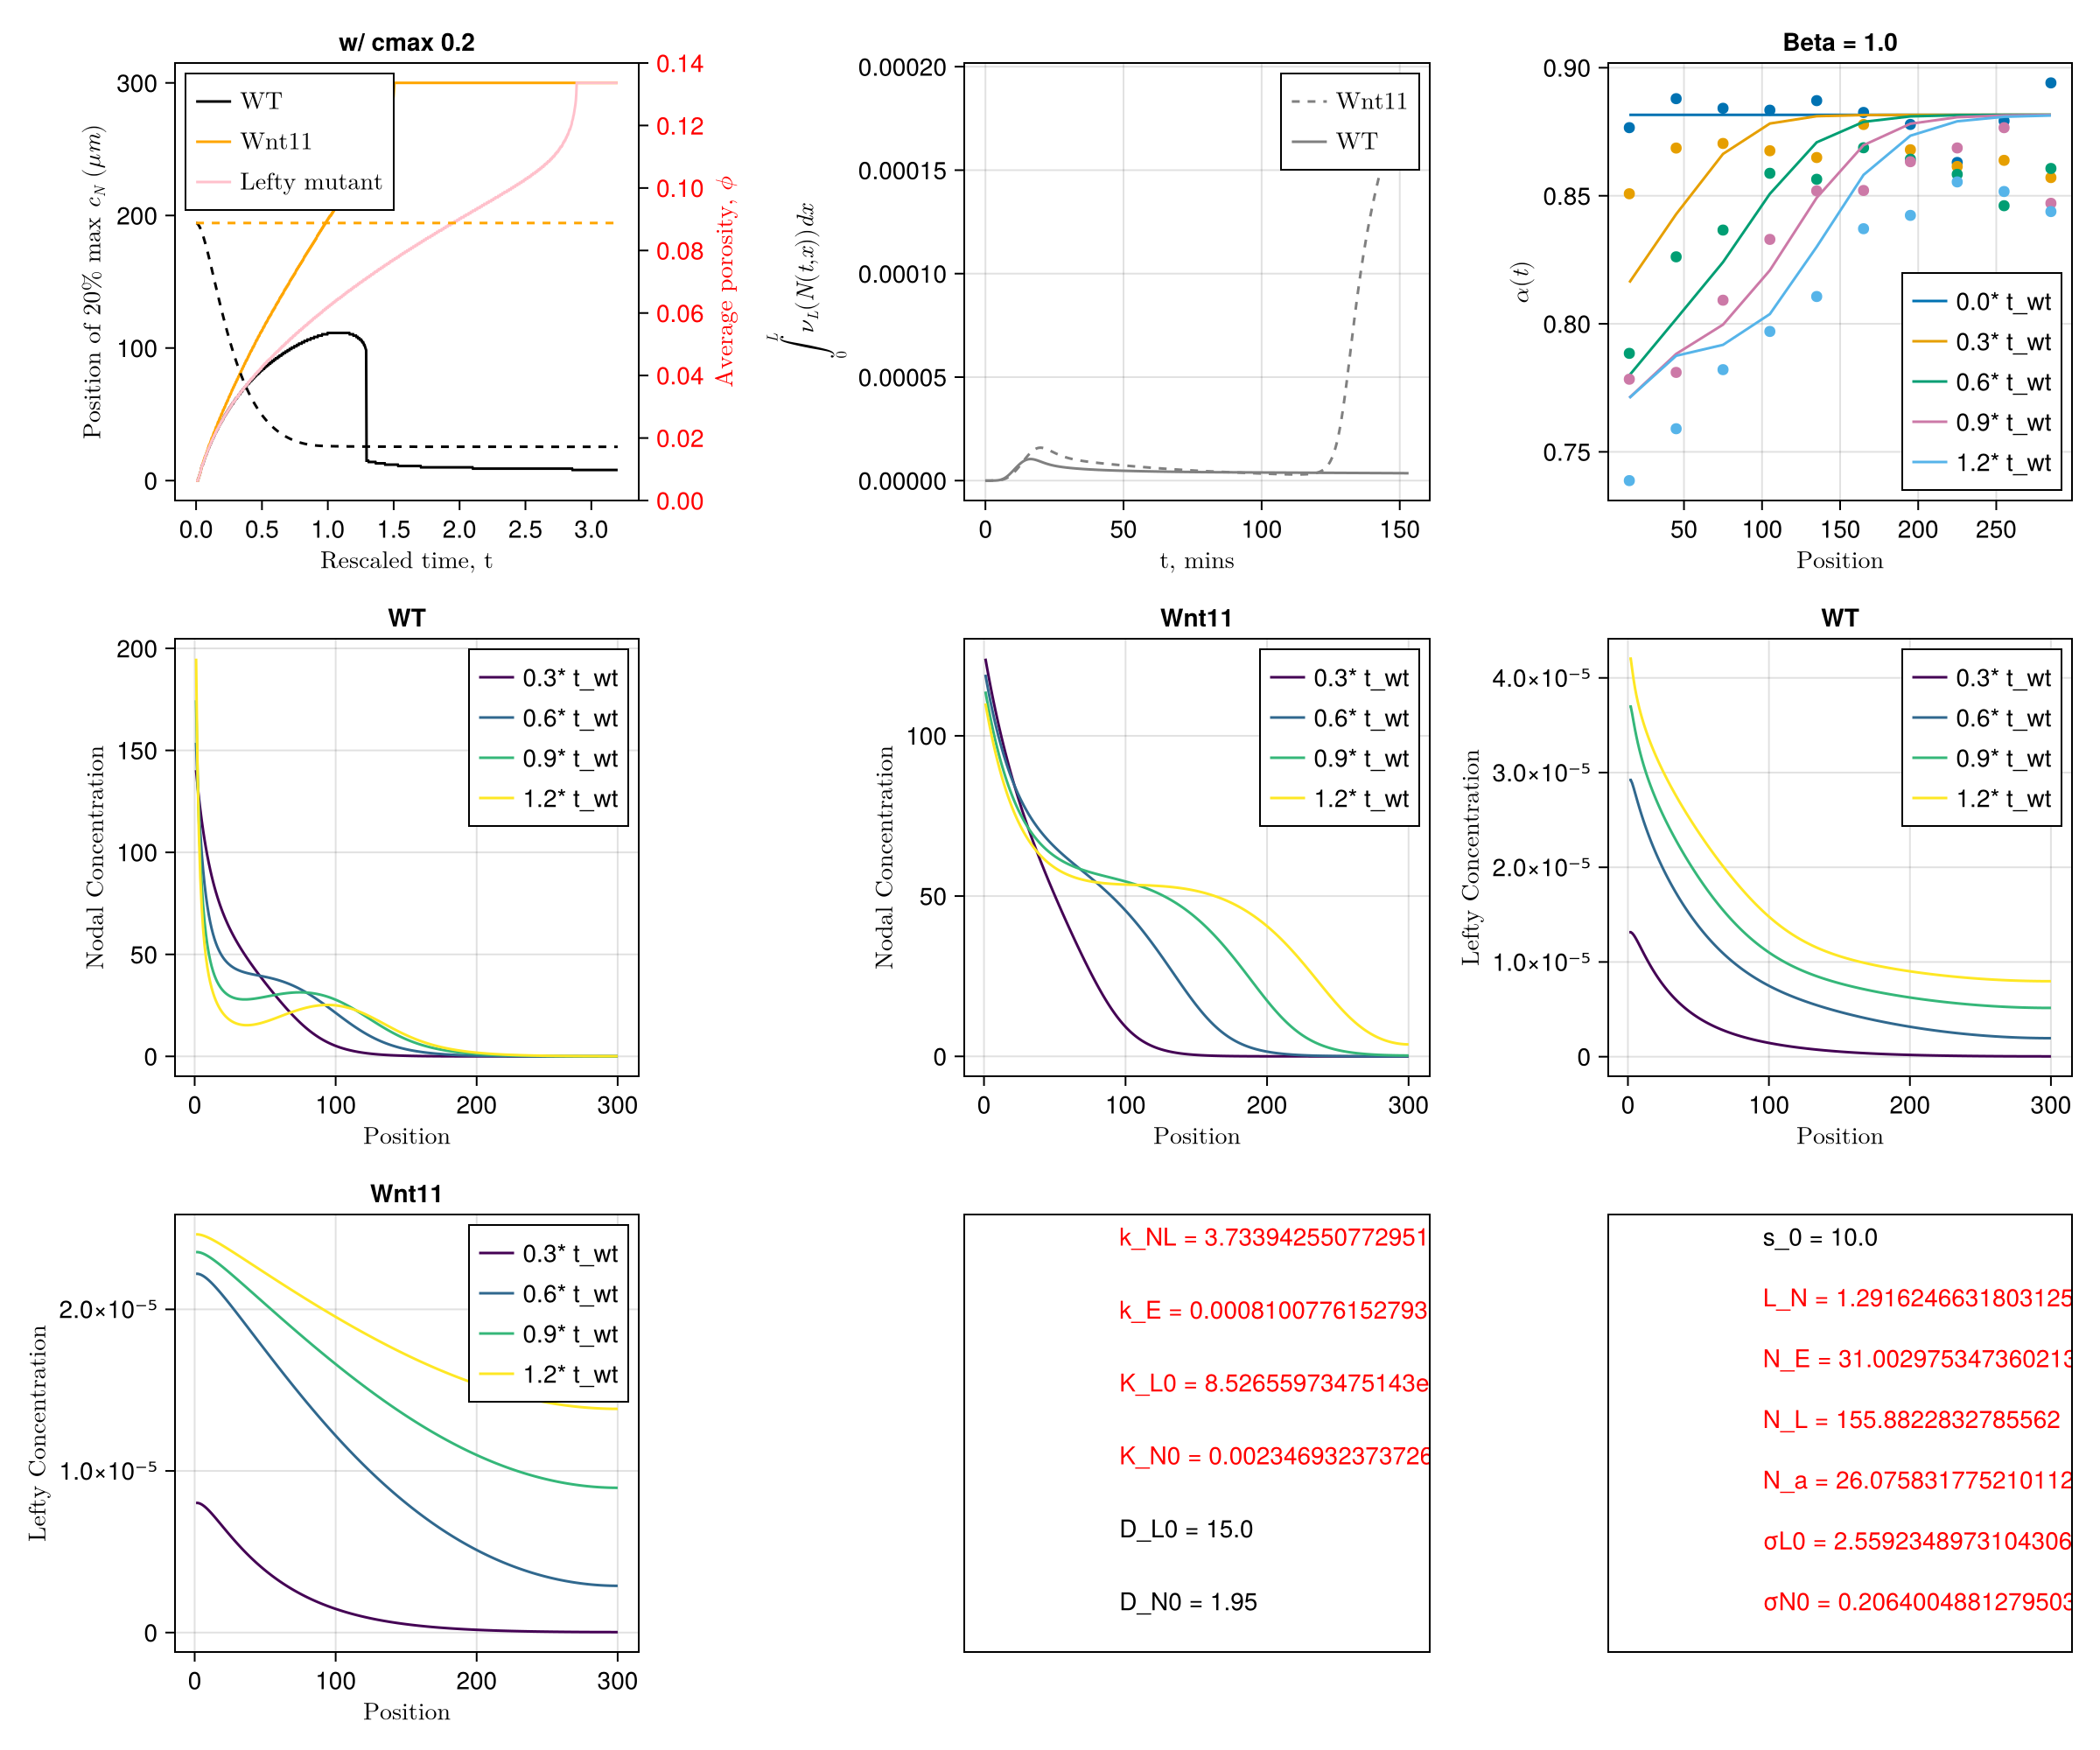

In [30]:
fig = Figure(size = (1200,1000))

fig = plot_summary!(fig,[sim_tuple[:DN0],sim_tuple[:DL0],sim_tuple[:kN0],sim_tuple[:kL0],sim_tuple[:kE],sim_tuple[:kNL],sim_tuple[:σN0],sim_tuple[:σL0],sim_tuple[:Na],sim_tuple[:NL],sim_tuple[:NE],sim_tuple[:LN],sim_tuple[:s0]],prob)

fig

In [ ]:
save(plotsdir(exp_name * "/OptFits/Summary_Sweep_P1.pdf"),fig)

In [ ]:
fig = Figure(size = (1200,1000))

de_abstol = 1e-11
de_reltol = 1e-9

fig = plot_summary!(fig,[sim_tuple[:DN0],sim_tuple[:DL0],sim_tuple[:kN0],sim_tuple[:kL0],sim_tuple[:kE],sim_tuple[:kNL],sim_tuple[:σN0],0.075*sim_tuple[:σL0],sim_tuple[:Na],sim_tuple[:NL],sim_tuple[:NE],sim_tuple[:LN],0.5*sim_tuple[:s0]],prob)

fig

In [ ]:
sol = solve(prob, p = p_opt, FBDF(),abstol = de_abstol,reltol = de_reltol,maxiters = 1e6,callback = TerminateSteadyState(1e-6,1e-4),isoutofdomain = (u,p,t) -> any(x->x<0, u));
sol_lm = solve(prob, p = p_cp_opt, FBDF(),abstol = de_abstol,reltol = de_reltol, maxiters = 1e6,callback = TerminateSteadyState(1e-6,1e-4),isoutofdomain = (u,p,t) -> any(x->x<0, u));
sol_cp = solve(prob, p = p_lm_opt, FBDF(),abstol = de_abstol,reltol = de_reltol,maxiters = 1e6,callback = TerminateSteadyState(1e-6,1e-4),isoutofdomain = (u,p,t) -> any(x->x<0, u));

In [ ]:
(t_grid_alpha,dyn_alpha),(t_plot,(level_x_wt_rescaled,level_x_cp_rescaled,level_x_lm_rescaled )),(porosity_dyn,porosity_dyn_cp),c_level,(sol,sol_cp,sol_lm) = get_alpha_xmax_lambda(pv_orig,prob,0.2);

In [ ]:
fig = Figure(size = (500,300))

ax = Axis(fig[1,1], xlabel = L"\text{Position}", ylabel= L"α(t)" )

for (n,d) in enumerate(dyn_alpha)
    lines!(ax,alpha_x,d, label = string(alpha_data_times_norm[n])* "* t_wt")
    scatter!(ax,alpha_x,alpha_data[:,n+1])
end

axislegend(ax,position = :rb)

save(plotsdir(exp_name * "/OptFits/Alpha_over_time.pdf"),fig)

fig

In [ ]:
fig = Figure(size = (500,300))

ax = Axis(fig[1,1], xlabel = L"\text{Rescaled time, t}", ylabel= L"\text{Position of 20% max } c_N \text{ } (μm) ",ygridvisible = false,xgridvisible = false,title = "w/ cmax lambda quantification - 0.1")
ax_por = Axis(fig[1,1], xlabel = L"\text{Rescaled time, t}", ylabel= L"\text{Average porosity, } \phi", yaxisposition = :right,ylabelcolor = :red,yticklabelcolor = :red,ygridvisible = false,xgridvisible = false,xticksvisible = false)

hidexdecorations!(ax_por)

lines!(ax,t_plot,level_x_wt_rescaled,color = :black,label = L"\text{WT}")
lines!(ax,t_plot,level_x_cp_rescaled,color = :orange,label = L"\text{Wnt11}")
lines!(ax,t_plot,level_x_lm_rescaled,linestyle = :dash,color = :pink,label = L"\text{Lefty mutant}")

lines!(ax_por,t_plot,porosity_dyn ,linestyle = :dash,color = :black,label = L"\text{ϕ}")
lines!(ax_por,t_plot,porosity_dyn_cp ,linestyle = :dash,color = :orange,label = L"\text{ϕ}")

# lines!(ax,exp_times_times_norm ,data[:,"SLB"],color = :blue)
# lines!(ax,exp_times_times_norm ,data[:,"WT"],color = :black)

axislegend(ax,position = :rc)

ylims!(ax_por,0.,0.14)
# ylims!(ax,0.,300)
ax.xticks = (0:0.5:3.5,string.(0:0.5:3.5))

ax_por.yticks = (0:0.02:0.14,string.(0:0.02:0.14))

save(plotsdir(exp_name * "/OptFits/Fig3E_xmax_over_time.pdf"),fig)

# (DN0 = 1.945, DL0 = 14.98, kN0 = 1.25e-7, kL0 = 7.6e-7, kE = 0.00051, kNL = 9.99, σN0 = 0.1, σL0 = 0.0012, Na = 316.228, NL = 1000.0, NE = 23.61709999999997, mN = 2, mL = 8, mNL = 2, LN = 1.58114, s0 = 28.0)

fig

In [ ]:
p_opt

In [ ]:
safesave("OptimizationRuns/" * exp_name * ".jld2", Dict("Params"=>ro,"Obj" => obj))

In [ ]:
# to_plot = [:wt_t0,:cp_t0,:xmax_peak_ratio,:wt_xMax,:cp_xMax,:wt_d0,:cp_d0,:lm_d0,:alpha_mse]

# fig = Figure(size = (760,760))

# grid_ax = Tuple.(findall(x->x>0,ones(3,3)))

# for (n,metric) in enumerate(to_plot)
#     if metric  == :alpha_mse
#         ax = Axis(fig[grid_ax[n]...],xlabel = metric_names_latex[metric],xscale = log10)
#         hist!(ax,map(x->transformations[metric](x[metric]),sim_res),normalization = :probability,color = (:grey,0.6),bins = 50)
#         vlines!(ax,transformations[metric](orig_metrics[metric]),color = :blue,linestyle = :dash)
#         vlines!(ax,transformations[metric](p_opt_metrics[metric]),color = :green,linestyle = :dash)
#     else
#         ax = Axis(fig[grid_ax[n]...],xlabel = metric_names_latex[metric])
#         hist!(ax,map(x->transformations[metric](x[metric]),sim_res),normalization = :probability,color = (:grey,0.6))
#         vlines!(ax,transformations[metric](data_metrics[metric]),color = :red,linestyle = :dash, label = L"\text{Experiment}")
#         vlines!(ax,transformations[metric](orig_metrics[metric]),color = :blue,linestyle = :dash, label = L"\text{Start param.}")
#         vlines!(ax,transformations[metric](p_opt_metrics[metric]),color = :green,linestyle = :dash, label = L"\text{Opt param.}")
#     end

#     if metric == :xmax_peak_ratio
#         axislegend(ax,position = :rt)
#     end

# end

# save(plotsdir(exp_name * "/OptFits/Summary_metrics.pdf"),fig)

# fig

In [ ]:
ro_pow,obj_pow = optimize_params(prob,0.1,pv_orig,lb_pow,ub_pow,200)

In [ ]:
p_opt